In [89]:





import datetime
import pytz
import pandas as pd
import MetaTrader5 as mt5
import matplotlib.pyplot as plt
import numpy as np
import pandas_ta as ta






In [90]:





# 30 min time frame
frameM30 = mt5.TIMEFRAME_M30

#1 min time frame
frameM1 = mt5.TIMEFRAME_M1

# 1 hour time frame
frameH1 = mt5.TIMEFRAME_H1





In [91]:





def getAssetList(assetSet = None):
    assetList = []
    if assetSet == 1:
        assetList = ['EURUSD', 'USDCHF']
    return assetList

        





In [92]:







## Defining the getQuotes method

def getQuotes(mt5TimeFrame, year = 2020, month = 1, day = 1, asset ='EURUSD'):
    
    ## Establishing the connection to MetaTrader 5
    if not mt5.initialize():
        print(f'MT5 initialization failed: Error code = {mt5.last_error}')
        quit()

    # Current time
    currentTime = datetime.datetime.now()

    # Defining the timezone and created utcFrom and utcTo dates
    timeZone = pytz.timezone('Asia/Kolkata')
    utcFrom = datetime.datetime(year, month, day, tzinfo = timeZone)
    utcTo = datetime.datetime(currentTime.year, currentTime.month, currentTime.day, tzinfo = timeZone)
    
    # Retrieving the data and returning it after converting it to pd dataframe
    return pd.DataFrame(mt5.copy_rates_range(asset, mt5TimeFrame, utcFrom, utcTo))







In [93]:



df = getQuotes(frameM30, 2023)
df





,time,open,high,low,close,tick_volume,spread,real_volume
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0
...,...,...,...,...,...,...,...,...
10075,1697837400,1.05879,1.05961,1.05870,1.05920,1812,9,0
10076,1697839200,1.05921,1.05943,1.05891,1.05913,1496,9,0
10077,1697841000,1.05913,1.05927,1.05879,1.05918,1593,9,0
10078,1697842800,1.05918,1.05934,1.05913,1.05922,1089,9,0


In [94]:



def psychologicalLine(df, period=20):
    df['psychologicalLine'] = ta.psl(close=df['close'], length=period)
    return df



In [95]:

period = 20
smalength=50

df = psychologicalLine(df, period)
df['sma'] = ta.sma(close=df['close'], length=smalength)

df


,time,open,high,low,close,tick_volume,spread,real_volume,psychologicalLine,sma
0,1672617600,1.06959,1.07017,1.06936,1.06937,71,54,0,NaN,NaN
1,1672619400,1.06936,1.06965,1.06883,1.06892,2833,71,0,NaN,NaN
2,1672621200,1.06892,1.06978,1.06873,1.06968,212,54,0,NaN,NaN
3,1672623000,1.06968,1.07021,1.06957,1.07021,208,54,0,NaN,NaN
4,1672624800,1.07012,1.07052,1.06953,1.06965,220,22,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
10075,1697837400,1.05879,1.05961,1.05870,1.05920,1812,9,0,45.0,1.058190
10076,1697839200,1.05921,1.05943,1.05891,1.05913,1496,9,0,45.0,1.058181
10077,1697841000,1.05913,1.05927,1.05879,1.05918,1593,9,0,45.0,1.058204
10078,1697842800,1.05918,1.05934,1.05913,1.05922,1089,9,0,50.0,1.058215


In [96]:



"""Psychological Line (PSL)

The Psychological Line is an oscillator-type indicator that compares the
number of the rising periods to the total number of periods. In other
words, it is the percentage of bars that close above the previous
bar over a given period.

Sources:
    https://www.quantshare.com/item-851-psychological-line
"""

buyIndices=[]
sellIndices=[]

buys=[]
sells=[]

position = None

sl = 0.5 / 100
tp = 2.0 / 100

slamount = None
tpamount = None


for i in range(len(df)):
    if (i > 0) and (position is None) and (df.iloc[i]['close'] > df.iloc[i]['sma']) and (df.iloc[i - 1]['close'] < df.iloc[i -1]['sma']) and (df.iloc[i]['psychologicalLine'] > 50):
        buyIndices.append(i)
        buys.append(df.iloc[i]['close'])
        position = 'long'
        slamount = df.iloc[i]['close'] - (sl * df.iloc[i]['close'])
        tpamount = df.iloc[i]['close'] + (tp * df.iloc[i]['close'])
    if (i > 0) and (position == 'long') and (
        #(
        #    (df.iloc[i]['close'] < df.iloc[i]['sma']) and
        #    (df.iloc[i - 1]['close'] > df.iloc[i - 1]['sma']) and
        #    (df.iloc[i]['psychologicalLine'] < 50)
        #) or (
        #     df.iloc[i]['close'] <= slamount
        #) or (
            df.iloc[i]['close'] >= tpamount
        #)
    ):
        sellIndices.append(i)
        sells.append(df.iloc[i]['close'])
        position = None
        slamount = None
        tpamount = None





In [97]:

print(buys)
print(sells)

print(buyIndices)
print(sellIndices)


[1.06763, 1.08807, 1.12441]
[1.08938, 1.10994]
[57, 775, 6792]
[726, 6610]


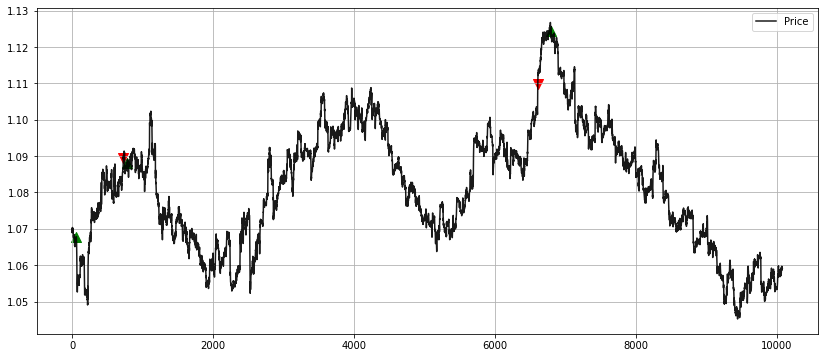

In [98]:

plt.figure(figsize=(14, 6))
plt.plot(df['close'], label='Price', color='black', alpha=0.9)
plt.scatter(df.iloc[buyIndices].index, df.iloc[buyIndices]['close'], marker = '^', color = 'g', s = 100)
plt.scatter(df.iloc[sellIndices].index, df.iloc[sellIndices]['close'], marker = 'v', color = 'r', s = 100)
plt.legend()
plt.grid(True)
plt.show()



In [99]:




brokerage = 1 / 100

wins = 0
losses = 0

profit = 0
loss = 0

averageprofit = 0
averageloss = 0

netresult = ''

for i in range(len(sells)):
    maximum = max(sells[i], buys[i])
    brokerageAmount = brokerage * maximum
    diff = sells[i] - buys[i] - brokerageAmount
    if (diff > 0):
        wins += 1
        profit += diff
    if (diff < 0):
        losses += 1
        loss += abs(diff)

if (profit > loss):
    netresult = 'Win'
elif (profit == loss):
    netresult = 'None'
else:
    netresult = 'Loss'

if profit and wins:
    averageprofit = profit / wins

if loss and losses:
    averageloss = loss / losses

hitratio = (wins / (wins + losses)) * 100
profitfactor = (profit / loss)
expectancy = (averageprofit * hitratio) - (averageloss * (1 - hitratio))
riskreward = (averageprofit / averageloss)

print(f'''
    Net result = {netresult}
    Hit ratio = {hitratio} %
    Profit factor = {profitfactor} {{currency}}
    Expectancy = {expectancy} {{currency}}
    Realised risk reward ratio = {riskreward} {{currency}}
''')







    Net result = Win
    Hit ratio = 100.0 %
    Profit factor = inf {currency}
    Expectancy = 1.0813399999999886 {currency}
    Realised risk reward ratio = inf {currency}



C:\Users\Sparsh\AppData\Local\Temp\ipykernel_11404\1222113937.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  profitfactor = (profit / loss)
C:\Users\Sparsh\AppData\Local\Temp\ipykernel_11404\1222113937.py:41: RuntimeWarning: divide by zero encountered in double_scalars
  riskreward = (averageprofit / averageloss)
